In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [221]:
N = 50

X = np.array([
    np.ones(N),
    np.concatenate([
        np.random.random_sample(N//2) + 0.4,
        np.random.random_sample(N//2) - 0.4
    ]),
    np.concatenate([
        np.random.random_sample(N//2) + 0.2,
        np.random.random_sample(N//2) - 0.2
    ])
]).T

dims = X.shape[1]

Y = np.concatenate([np.repeat([-1], N//2), np.ones(N//2)])

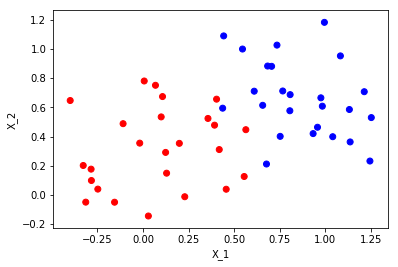

In [350]:
colors = ['red' if y == 1 else 'blue' for y in Y]

plt.scatter(X[:, 1], X[:, 2], c=colors)
plt.xlabel("X_1")
plt.ylabel("X_2")

In [202]:
def logit(p):
    return np.log(p/(1-p))

def logistic(s):
    return np.e**s / (1 + np.e ** s)

logit = np.vectorize(logit)
logistic = np.vectorize(logistic)

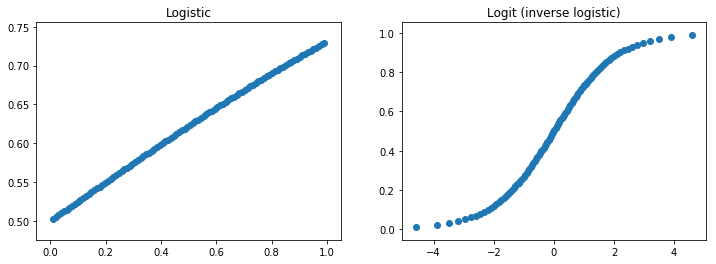

In [223]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
x_grid = np.linspace(.01, .99, 100)

axes[0].scatter(x_grid, logistic(x_grid))
axes[0].set_title("Logistic")
axes[1].scatter(logit(x_grid), x_grid)
axes[1].set_title("Logit (inverse logistic)")

In [204]:
W = np.zeros(dims)

In [125]:
def gradient_error_pointwise(w, x, y):
    return -(x * y * logistic( -y * w.T @ x))

def gradient_error(w):
    return np.sum([gradient_error_pointwise(w, X[i, :], Y[i]) for i in range(N)], axis=0) / N

### Batch gradient descent

In [197]:
def calc_mispredictions(x, w, y, threshold=0.5):
    return sum((logistic(x @ w) > threshold) != (y > 0))

In [241]:
import time

start = time.time()

eta = .01 # learning rate
steps = 5000
W = np.random.normal(0, .0001, size=dims)
errors = []
mispredictions = []

for i in range(steps):
    g = gradient_error(W)
    W = W + eta * (-g)
    
    errors.append(g)
    mispredictions.append(calc_mispredictions(X, W, Y))

errors = np.array(errors)

print('This took {} seconds'.format(time.time() - start))

This took 8.425995111465454 seconds


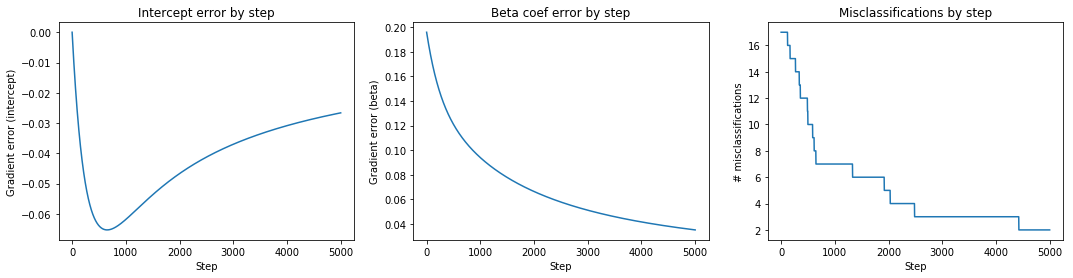

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axes[0].plot(np.linspace(0, steps, steps), errors[:, 0])
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient error (intercept)")
axes[0].set_title("Intercept error by step")

axes[1].plot(np.linspace(0, steps, steps), errors[:, 1])
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Gradient error (beta)")
axes[1].set_title("Beta coef error by step")

axes[2].plot(np.linspace(0, steps, steps), mispredictions)
axes[2].set_xlabel("Step")
axes[2].set_ylabel("# misclassifications")
axes[2].set_title("Misclassifications by step")

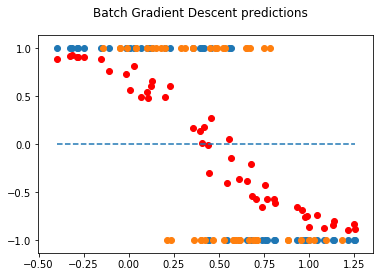

In [239]:
plt.suptitle("Batch Gradient Descent predictions")
plt.scatter(X[:, 1], Y)
plt.scatter(X[:, 2], Y)
plt.scatter(X[:, 1], logistic(X @ W) * 2 - 1, color="red")
plt.plot([X.min(), X.max()], [0, 0], linestyle="--")

In [395]:
X[1, ]

array([ 1.        ,  1.21471134,  0.70745904])

In [409]:
preds = logistic(X @ W)

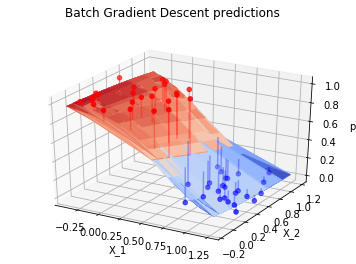

In [418]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.suptitle("Batch Gradient Descent predictions")

x, y = np.meshgrid(X[:, 1], X[:, 2])
Z = np.array([logistic(np.array([1, x, y]) @ W) for x, y in zip(np.ravel(x), np.ravel(y))]).reshape(x.shape)
ax.plot_surface(x, y, Z, cmap=cm.coolwarm)

ax.scatter3D(X[:, 1], X[:, 2], Y == 1, c=colors)

for i in range(len(Y)):
    ax.plot(
        (X[i, 1], X[i, 1]),
        (X[i, 2], X[i, 2]),
        (preds[i], Y[i] == 1),
        color=('red' if Y[i] == 1 else 'blue'),
        alpha=0.3
    )

ax.set_xlabel("X_1")
ax.set_ylabel("X_2")
ax.set_zlabel("p")

### Stochastic gradient descent

In [240]:
import time

start = time.time()
W_sgd = np.random.normal(0, .0001, size=dims)
errors_sgd = []
mispredictions_sgd = []

for i in range(steps):
    n = np.random.randint(0, len(Y))
    
    x = X[n, :]
    y = Y[n]
    g = gradient_error_pointwise(W_sgd, x, y)
    
    errors_sgd.append(g)
    mispredictions_sgd.append(calc_mispredictions(X, W_sgd, Y))
    
    W_sgd += eta * (-g)

errors_sgd = np.array(errors_sgd)
print("This took {} seconds".format(time.time() - start))

This took 1.183772087097168 seconds


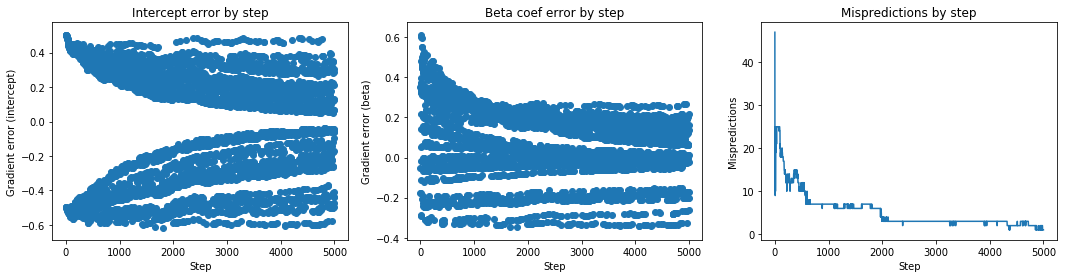

In [235]:
plt.suptitle("SGD Errors by steps")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axes[0].scatter(np.linspace(0, steps, steps), errors_sgd[:, 0])
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient error (intercept)")
axes[0].set_title("Intercept error by step")

axes[1].scatter(np.linspace(0, steps, steps), errors_sgd[:, 1])
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Gradient error (beta)")
axes[1].set_title("Beta coef error by step")

axes[2].plot(np.linspace(0, steps, steps), mispredictions_sgd)
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Mispredictions")
axes[2].set_title("Mispredictions by step")

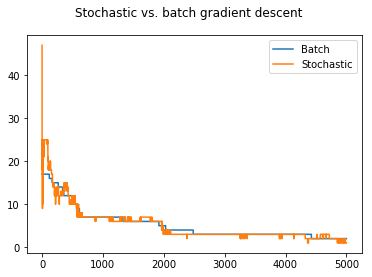

In [236]:
plt.suptitle("Stochastic vs. batch gradient descent")
plt.plot(np.linspace(0, steps, steps), mispredictions, label="Batch")
plt.plot(np.linspace(0, steps, steps), mispredictions_sgd, label="Stochastic")

plt.legend()

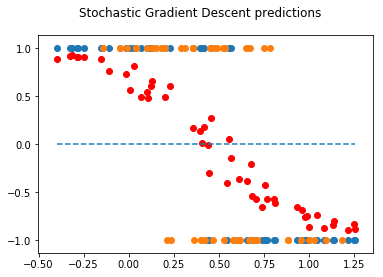

In [238]:
plt.suptitle("Stochastic Gradient Descent predictions")
plt.scatter(X[:, 1], Y)
plt.scatter(X[:, 2], Y)
plt.scatter(X[:, 1], logistic(X @ W) * 2 - 1, color="red")
plt.plot([X.min(), X.max()], [0, 0], linestyle="--")